### Imports

In [1]:
%env SM_FRAMEWORK=tf.keras

import ssl
from sys import platform

import keras
import segmentation_models as sm

from config import *
from util import *

print('Done')

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.
Done


### Load Datasets

In [2]:
prep_input = sm.get_preprocessing(BACKBONE)  # vgg16 preprocessing

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint(best_model_name, save_weights_only=True,
                                    save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [3]:
# datasets
train = Dataset(
    images_dir=train_dir + 'XTrain/',
    masks_dir=train_dir + 'YTrain/',
    classes=CLASSES,
    aug=get_augmentation(),
    prep=get_preprocess()
)
val = Dataset(
    images_dir=val_dir + 'XValidate/',
    masks_dir=val_dir + 'YValidate/',
    classes=CLASSES,
    aug=get_augmentation(),
    prep=get_preprocess(),
)

train_dataloader = Dataloader(train, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = Dataloader(val, batch_size=1, shuffle=False)


print('Done')

Done


### Define Optimizer and Loss Functions

In [4]:
# define optimizer
optim = tf.keras.optimizers.Adam(LR)

# segmentation models losses
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metrics = [sm.metrics.IOUScore(threshold=5), sm.metrics.FScore(threshold=0.5)]

print('Done')

Done


### Define and Compile UNet Model

In [5]:
# bypass ssl context if not on win32 (this method is not recommended but easy)
if platform != 'win32':
    # noinspection PyProtectedMember,PyUnresolvedReferences
    ssl._create_default_https_context = ssl._create_unverified_context
    print('context set')

print('Done')

Done


In [6]:
# create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

# compile keras model with defined optimizer, loss and metrics
model.compile(optim, total_loss, metrics)

print('Done')

Done


### Train Model

In [15]:
history = model.fit(
    x=train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=5,
    callbacks=callbacks,
    validation_data=val_dataloader,
    validation_steps=len(val_dataloader),
)

Epoch 1/5
64/64 [==============================] - 252s 4s/step - loss: 0.1832 - iou_score: 9.3458e-11 - f1-score: 0.9507 - val_loss: 0.4035 - val_iou_score: 1.9713e-10 - val_f1-score: 0.7975
Epoch 2/5
64/64 [==============================] - 253s 4s/step - loss: 0.1383 - iou_score: 9.3458e-11 - f1-score: 0.9602 - val_loss: 0.1352 - val_iou_score: 1.9713e-10 - val_f1-score: 0.9650
Epoch 3/5
64/64 [==============================] - 226s 4s/step - loss: 0.1150 - iou_score: 9.3458e-11 - f1-score: 0.9646 - val_loss: 0.2438 - val_iou_score: 1.9713e-10 - val_f1-score: 0.8450
Epoch 4/5
64/64 [==============================] - 247s 4s/step - loss: 0.0963 - iou_score: 9.3458e-11 - f1-score: 0.9704 - val_loss: 0.5872 - val_iou_score: 1.9713e-10 - val_f1-score: 0.5611
Epoch 5/5
64/64 [==============================] - 266s 4s/step - loss: 0.0782 - iou_score: 9.3458e-11 - f1-score: 0.9762 - val_loss: 0.9369 - val_iou_score: 1.9713e-10 - val_f1-score: 0.3066


### Graph Model Loss

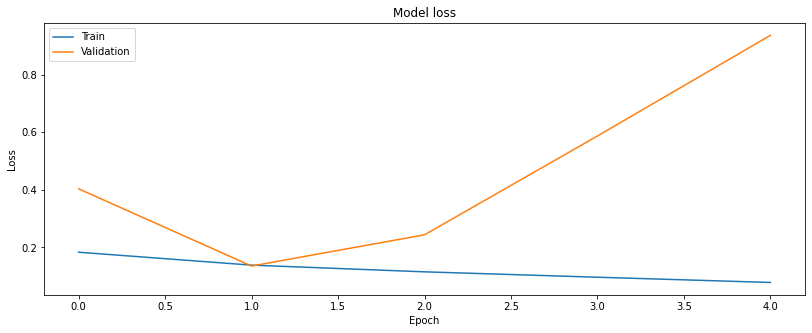

In [16]:
graph_loss(history)

### Model Evaluation

In [17]:
best_model_name = os.path.join(model_dir, 'best_model_9.h5')

# load best weights
model.load_weights(best_model_name)

In [18]:
# remake_test(200)

# load test dataset
test = Dataset(
    images_dir=test_dir + 'XTest',
    masks_dir=test_dir + 'YTest',
    classes=CLASSES,
    aug=get_augmentation(),
    prep=get_preprocess()
)
test_dataloader = Dataloader(test, batch_size=1, shuffle=False)

In [19]:
scores = model.evaluate(test_dataloader)
print_metrics(scores, metrics)

36/36 [==============================] - 11s 298ms/step - loss: 1.7296 - iou_score: 0.6944 - f1-score: 0.0010
Loss: 1.7296
mean iou_score: 0.69444
mean f1-score: 0.0010496


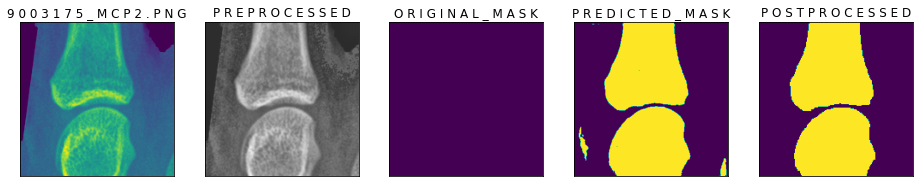

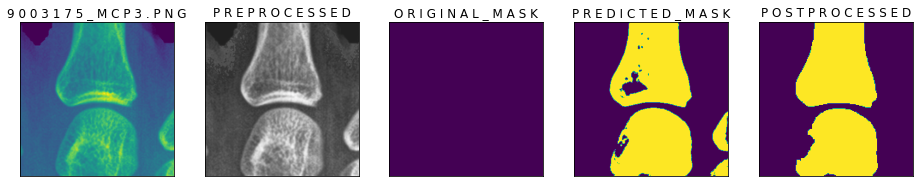

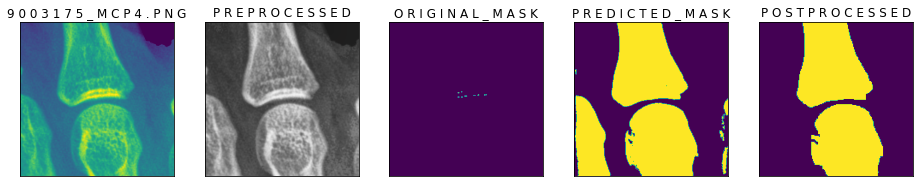

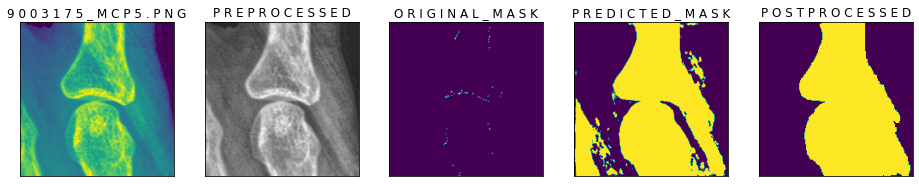

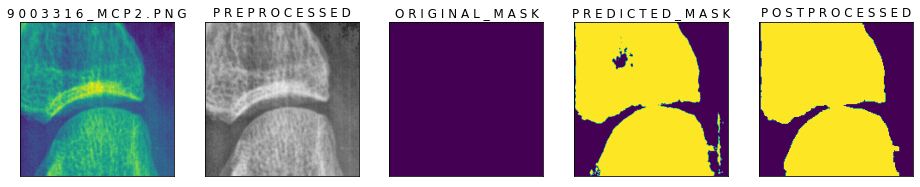

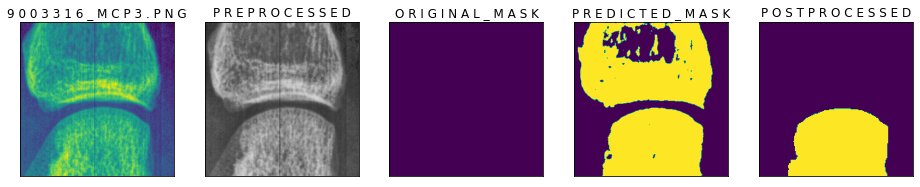

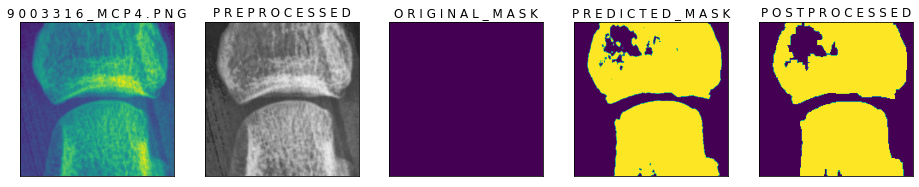

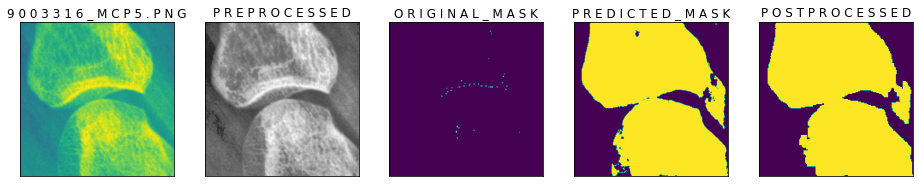

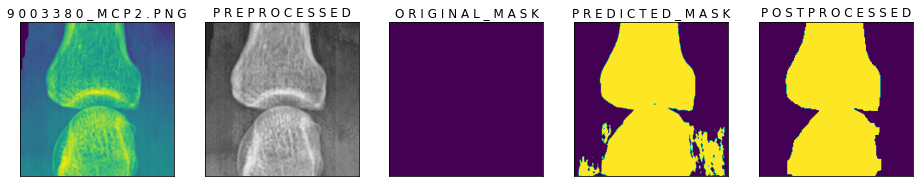

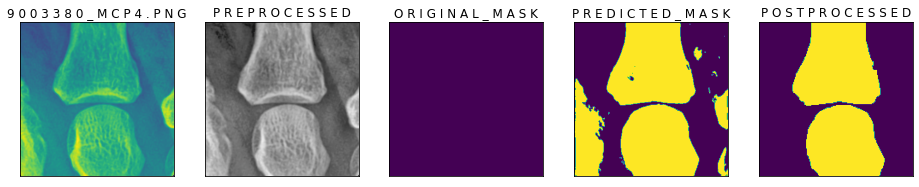

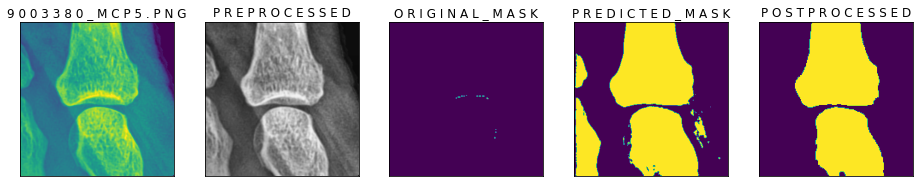

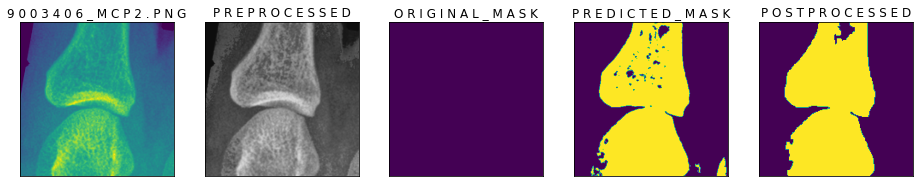

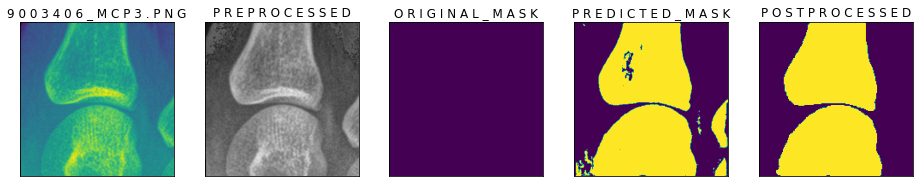

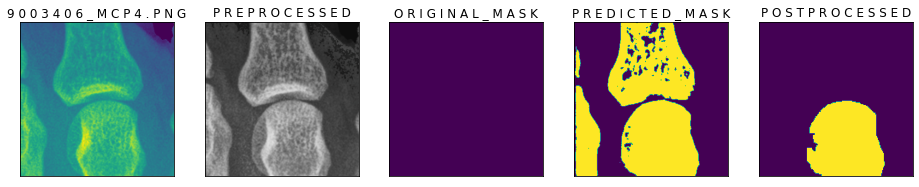

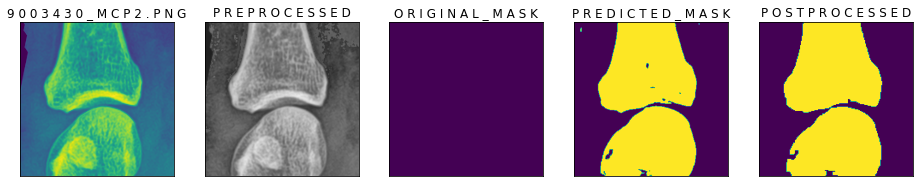

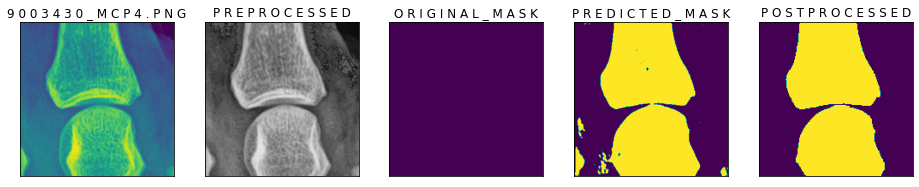

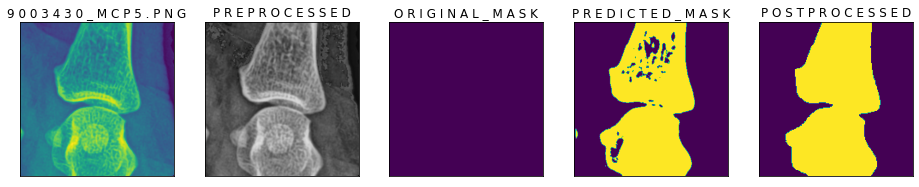

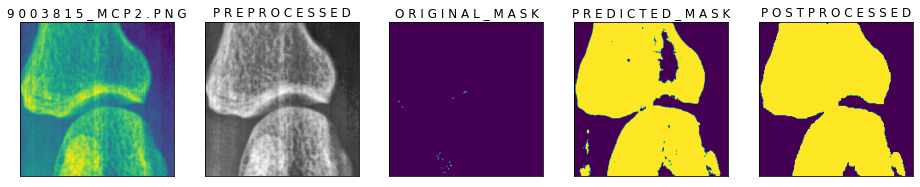

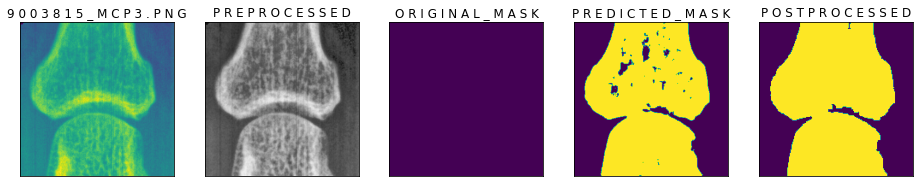

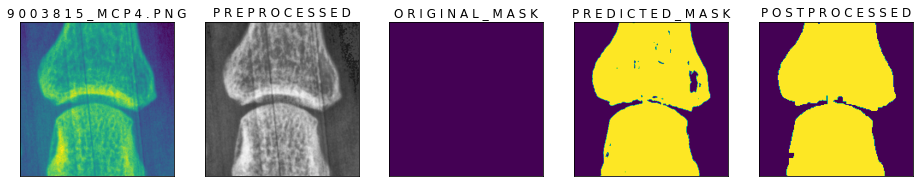

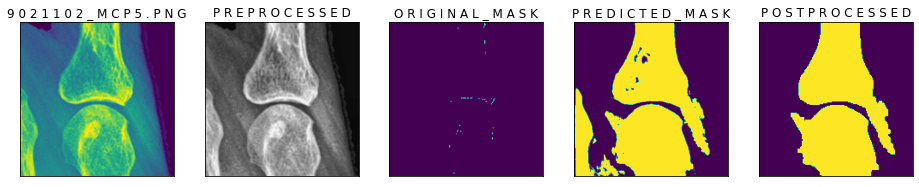

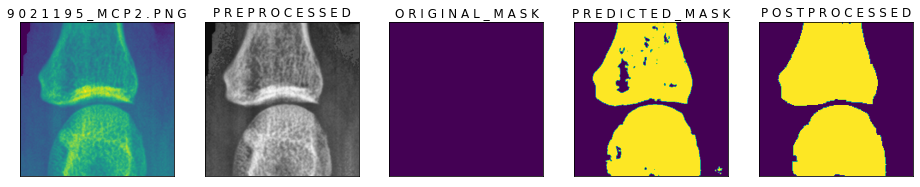

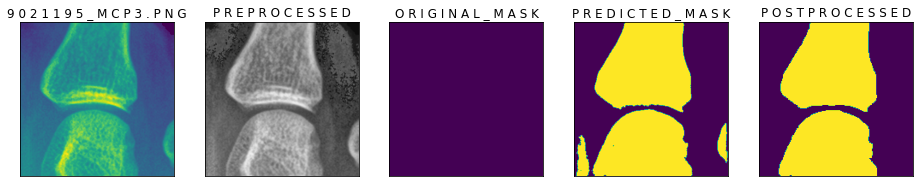

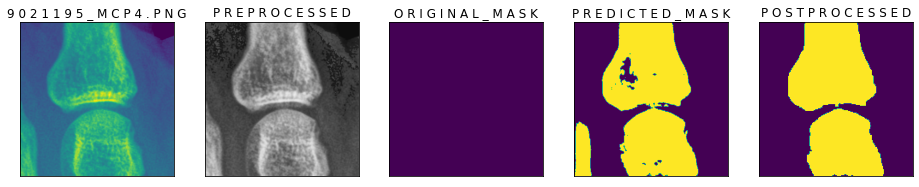

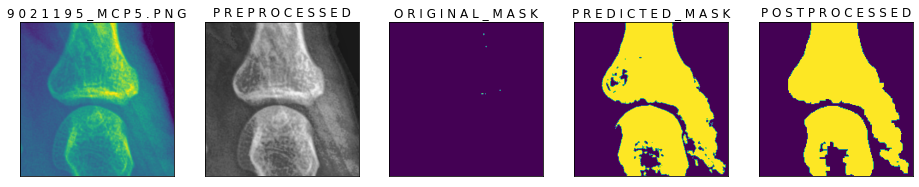

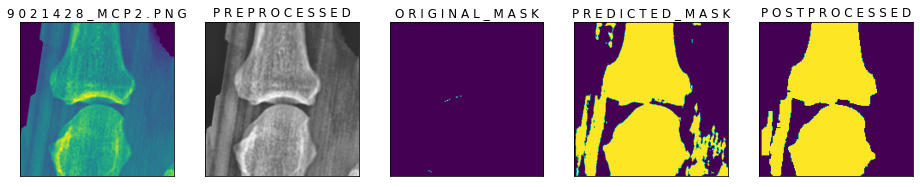

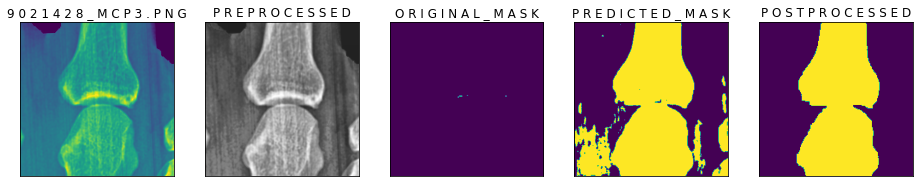

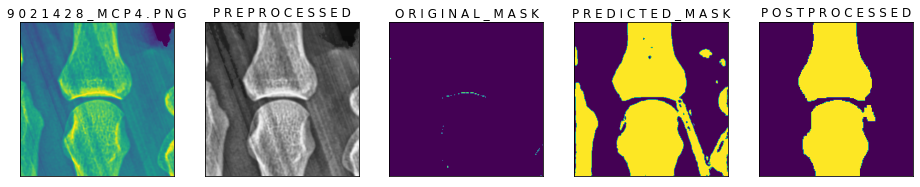

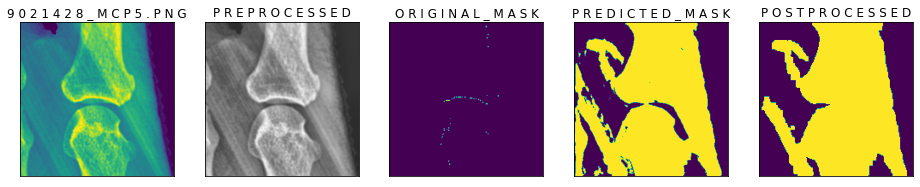

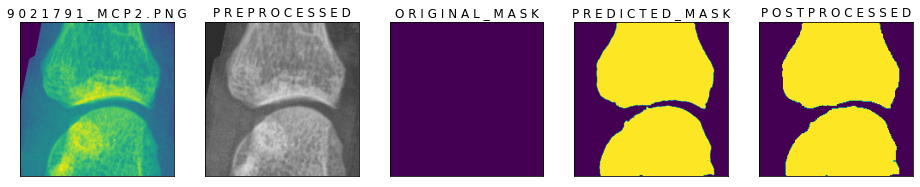

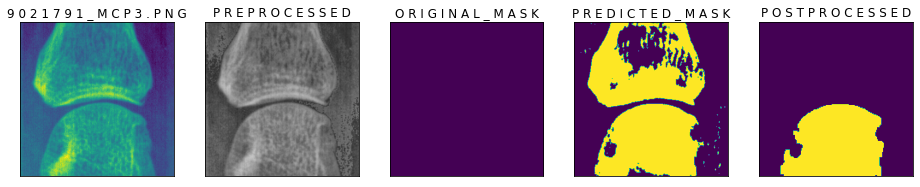

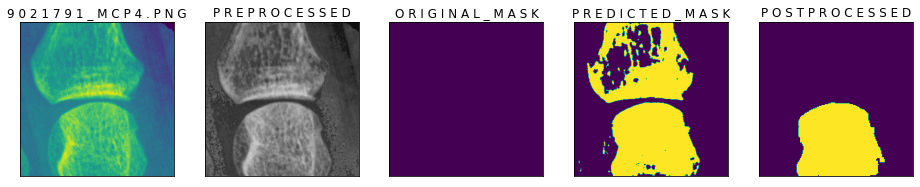

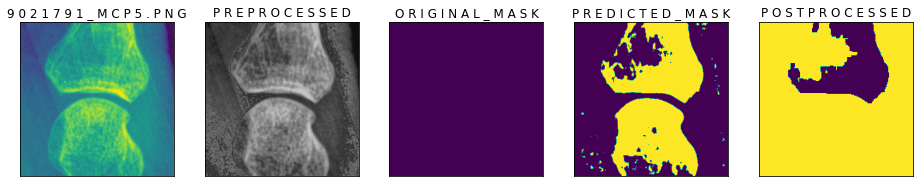

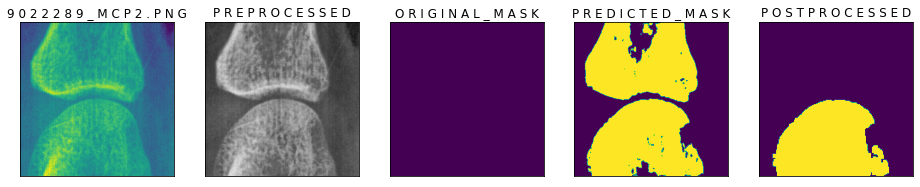

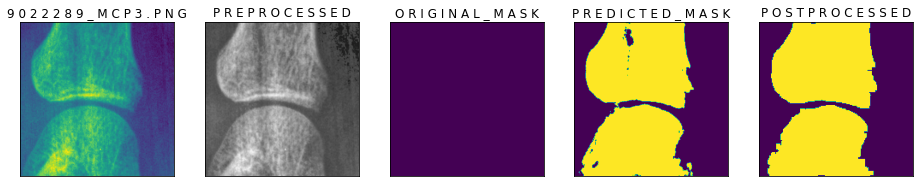

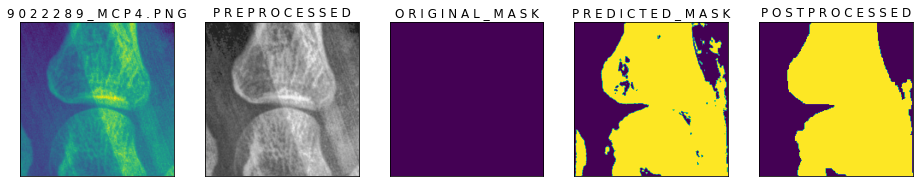

In [20]:
show_results(
    test,
    model,
    len(test),
    postprocess,
    show=True,
    save=False,
    out=output_dir,
    largest_only=True,
    region_fill=True,
)

### Full Dataset

In [ ]:
hands_dir = 'C:\\Users\\yangz1\\Desktop\\Research\\data\\hands\\'
masks_dir = 'C:\\Users\\yangz1\\Desktop\\Research\\data\\results\\2\\'

full = Dataset(
    images_dir=hands_dir,
    masks_dir=masks_dir,
    classes=CLASSES,
    aug=get_augmentation(),
    prep=get_preprocess()
)
full_dataloader = Dataloader(full, batch_size=1, shuffle=False)

output_dir = 'C:\\Users\\yangz1\\Desktop\\Research\\data\\results\\model1_2\\'

In [ ]:
post_args = {'largest_only': False, 'smooth': True}
show_results(
    full,
    model,
    len(full),
    postprocess,
    show=False,
    save=True,
    out=output_dir,
    **post_args
)

### Test on Separate 200 Samples

In [ ]:
hands_dir = 'data/samples/hands/'
masks_dir = 'data/samples/masks/'

test = Dataset(
    images_dir=hands_dir,
    masks_dir=masks_dir,
    classes=CLASSES,
    aug=get_augmentation(),
    prep=get_preprocess(fn=prep_input),
)

output_dir = 'data/samples/results/'
post_args = {'largest_only': True, 'smooth': False, 'region_fill': True}
show_results(
    dataset=test,
    model=model,
    n=len(test),
    postprocess=postprocess,
    show=False,
    save=True,
    out=output_dir,
    **post_args
)

### Alternative Accuracy Computations

In [ ]:
# accuracy by joint-pixel matching

ROI_PATH = '/Users/zilongyang/Files/Hand OA/data/roi'

def jpm(out):
    acc = 0
    for mask_name in os.listdir(out):
        hand_id = mask_name[:mask_name.index('_')]
        roi_path = os.path.join(ROI_PATH, hand_id + '_v06.txt')
        coords = strip_joint_coord(roi_path)
        a = joint_accuracy(os.path.join(out, mask_name), coords)
        acc += a

        # if a < 1:
        #     hand_path = os.path.join(hands_dir, '%s_v06.png' % hand_id)
        #     mask_path = os.path.join(output_dir, '%s_pred.png' % hand_id)
        #     hand = color_joints(hand_path, coords, color=[255, 0, 0])
        #     mask = color_joints(mask_path, coords, color=[255, 0, 0])
        #
        #     vis_arg = {hand_id: hand, 'mask': mask}
        #     vis(**vis_arg)

    n = len([f for f in os.listdir(out) if f.endswith('.png')])
    n_joints = int(n * 12)
    print('%f/%d = %f' % (acc, n, acc / n))
    print('%d/%d incorrect joints' % (n_joints - int(acc * 12), n_joints))

output_dir = '/Users/zilongyang/Files/Hand OA/hand_seg/data/samples/results'
jpm(output_dir)

In [ ]:
# accuracy by comparing masks with model 3's results

outs = os.listdir(output_dir)
i = 0
diff_total = 0
total = 0
acc_arr = np.zeros(shape=(len(full)), dtype=np.float64)
for out in outs:
    expect = full.get_mask(i)
    actual = os.path.join(output_dir, out)

    diff_count = mask_diff(expect, actual)
    diff_total += diff_count

    pixels = expect.shape[0] * expect.shape[1]
    total += pixels
    acc_arr[i] = 1 - diff_count / pixels
    i += 1

    from IPython.display import clear_output
    clear_output(wait=True)
    print('%s: %d/%d' % (out, diff_count, pixels))

print(diff_total)
print(total)
print('acc:', 1 - diff_total / total)

### Concatenate Hand and Mask into One Image

In [ ]:
ids = map(lambda x : int(x[:x.index('_')]), full.ids)
ids = np.array(list(ids))
ids = ids[np.argpartition(acc_arr, 10)[:10]]

for hand_id in ids:
    img1_path = 'C:\\Users\\yangz1\\Desktop\\Research\\data\\hands\\%d_v06.png' % hand_id
    img2_path = 'C:\\Users\\yangz1\\Desktop\\Research\\data\\results\\model1\\%d_v06_pred.png' % hand_id

    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    result = np.concatenate((img1, img2), axis=1)

    out_dir = 'C:\\Users\\yangz1\\Desktop\\test\\%d.png' % hand_id
    cv2.imwrite(out_dir, result)